# 2.4: Earthquake location and uncertainty via Monte Carlo Error Propagation

*Andrew Valentine & Malcolm Sambridge - Research School of Earth Sciences, The Australian National University - Last updated Aug. 2020*

In this practical, we look at Monte Carlo error propagation in a nonlinear inverse problem. 

As an example, we will consider is earthquake location.

Specifically, the practical is to set up an earthquake location problem and use a python script to iteratively update an earthquake location for the $(x,y,z)$ and origin time, $t$.  This will then be used as the basis of Monte Carlo error propagation. The tasks to be performed are:

1. Read in 25 seismic stations at locations across Switzerland together with arrival times from the source to each station.

2. Choose a random starting guess inside the region, a half space seismic wavespeed and tolerance for iterative location algorithm.
Note that the depth is fixed by this location routine to the starting guess, so set the depth to $z=-10 km$.

3. Apply the least squares iterative solution routine to this data set. Choose a tolerance parameter which determines when to stop the solver, e.g $tol=0.01$.

4. Make a plot showing the source location at each iteration relative to the seismic station.

5. Use Monte Carlo Error propagation by adding Gaussian noise to the data and repeating the location. Plot the cloud of solutions in selected planes. 

6. Calculate and plot the model covariance matrices for each pair of parameters at your final solution.

Things to consider. Does the iterative algorithm converge to a good enough solution? Do the Monte Carlo error ellipses look reasonable. What influences their shape?

In [2]:
%matplotlib inline
# setup libraries for exercises and practicals
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from inversionCourse import plotcovellipse as pc
import math
import scipy.io as sio
from inversionCourse import eqlocate as eq
from inversionCourse.plotcovellipse import plot_point_cov,plot_cov_ellipse
import pickle

**Task 1** First write a python script to read in the data, iteratively locate the earthquake and plot the results.

To locate the event you can use the supplied routine *eqlocate*.

Location 7.554340449459331 47.21934917923526 -10.0
Event time (seconds after 16:30) 40.100076982480914


/Users/malcolm/Dropbox/Teaching/EMSC8023/2020/Part II/Jupyter Practicals/Solutions/inversionCourse/eqlocate.py:75: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m=np.linalg.lstsq(G,res)[0]


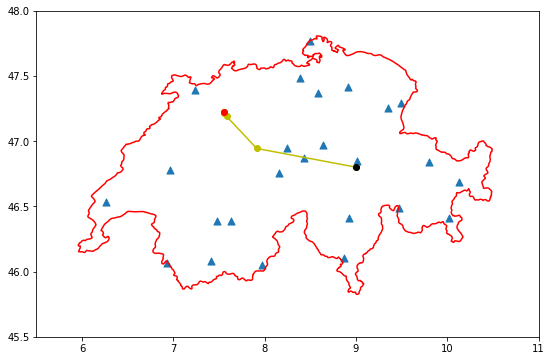

In [6]:
############
#    eloc
#############
pickle_eq = open("datasets/loctim.pickle","rb") # read in arrival time data and seismic velocities
[la,lo,el,ts,vp] = pickle.load(pickle_eq)

# load border.xy
pickle_b = open("datasets/border.pickle","rb") # read in plot border
[borderx,bordery] = pickle.load(pickle_b)
######## Start guess for location
x0=9
y0=46.8
z0=-10
######## locate earthquake
tol = [0.01,0.01]
sols, res =eq.eqlocate(x0,y0,z0,ts,la,lo,el,vp,tol)

sol = sols[-1]
tfinal = sols[-1,0] # First parameter is the origin time
xfinal = sols[-1,1] # Second parameter is the Longitude 
yfinal = sols[-1,2] # Third parameter is the Latitude 
zfinal = sols[-1,3] # Fourth parameter is the Depth 

print ('Location', xfinal,yfinal,zfinal)
print ('Event time (seconds after 16:30)',tfinal)

plt.figure(figsize=(9,6))
plt.plot(borderx,bordery,'r-')
plt.scatter(lo,la,s=50,marker='^')
plt.plot(sols[:,1],sols[:,2],'o-y') # solution updates
plt.plot(sols[0,1],sols[0,2],'ok') # initial guess
plt.plot(xfinal,yfinal,'or')
plt.xlim([5.5,11])
plt.ylim([45.5,48])
plt.show()

**Task 2** Now calculate 5000 Monte Carlo solutions by adding Gaussian random noise, $N(0,\sigma^2=0.2s)$ to each arrival time and relocate. Plot the cloud of solutions relative to the original solution.

/Users/malcolm/Dropbox/Teaching/EMSC8023/2020/Part II/Jupyter Practicals/Solutions/inversionCourse/eqlocate.py:75: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m=np.linalg.lstsq(G,res)[0]


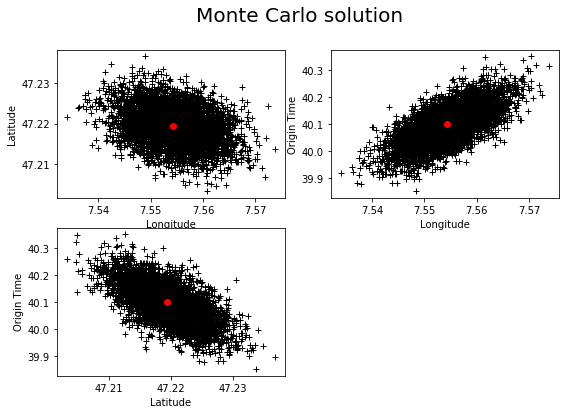

In [7]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

##############
#    Then use Monte Carlo error propagation to calculate confidence ellipses
##############

######## Start guess for location in degrees
x0=9
y0=46.8
z0=-10

ndata,n,sigma =len(la), 5000, 0.2 # Number of stations, Number of MC solutions, standard deviation of arrival time noise to be added.

MCsols=[]
for i in range(n):
    tsMC= ts +sigma*np.random.randn(ndata)
    sols,res=eq.eqlocate(x0,y0,z0,tsMC,la,lo,el,vp,tol)
    MCsols.append(sols[-1,:])
MCsols=np.array(MCsols)    
sols,res=eq. eqlocate(x0,y0,z0,ts,la,lo,el,vp,tol)

fig = plt.figure(figsize=(9,6))
fig.suptitle("Monte Carlo solution", fontsize=20)

ax1 = plt.subplot("221")
ax1.plot(MCsols[:,1],MCsols[:,2], 'k+')
ax1.plot(sols[-1,1],sols[-1,2], 'ro')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax2 = plt.subplot("222")
ax2.plot(MCsols[:,1],MCsols[:,0], 'k+')
ax2.plot(sols[-1,1],sols[-1,0], 'ro')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Origin Time')

ax3 = plt.subplot("223")
ax3.plot(MCsols[:,2],MCsols[:,0], 'k+')
ax3.plot(sols[-1,2],sols[-1,0], 'ro')
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Origin Time')

plt.show()

**Task 3** Now calculate the model covariance matrix from the Monte Carlo solutions, together with the standard deviation and hence the 95% confidence intervals for each parameter,

In [8]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 


###### Calculate covariance solutions numerically from MC solutions.
Cm_cov= np.cov(MCsols.T)
Cm_std= np.std(MCsols,axis=0)
print('Monte Carlo estimate of model covariance matrix\n',Cm_cov)
print('\n Monte Carlo estimate of model standard deviations in each parameter')
print(' Parameter 1: ',Cm_std[0])
print(' Parameter 2: ',Cm_std[1])
print(' Parameter 3: ',Cm_std[2])

sig_param1 = Cm_std[0]
sig_param2 = Cm_std[1]
sig_param3 = Cm_std[2]
print("\n Solution and 95% Confidence intervals ")
print(" Parameter 1 {:7.3f} [{:7.3f}, {:7.3f}]".format(sols[-1][0],sols[-1][0]-1.96*sig_param1,sols[-1][0]+1.96*sig_param1))
print(" Parameter 2 {:7.3f} [{:7.3f}, {:7.3f}]".format(sols[-1][1],sols[-1][1]-1.96*sig_param2,sols[-1][1]+1.96*sig_param2))
print(" Parameter 3 {:7.3f} [{:7.3f}, {:7.3f}]".format(sols[-1][2],sols[-1][2]-1.96*sig_param3,sols[-1][2]+1.96*sig_param3))


Monte Carlo estimate of model covariance matrix
 [[ 4.67714229e-03  2.51793834e-04 -1.98672917e-04  0.00000000e+00]
 [ 2.51793834e-04  2.98465924e-05 -7.77816001e-06  0.00000000e+00]
 [-1.98672917e-04 -7.77816001e-06  2.06577110e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 Monte Carlo estimate of model standard deviations in each parameter
 Parameter 1:  0.0683827965128816
 Parameter 2:  0.0054626571464417885
 Parameter 3:  0.004544620934616892

 Solution and 95% Confidence intervals 
 Parameter 1  40.100 [ 39.966,  40.234]
 Parameter 2   7.554 [  7.544,   7.565]
 Parameter 3  47.219 [ 47.210,  47.228]


**Task 4** Now plot the 68% and 95 % confidence ellipses projected onto selected axes relative to the original solution.

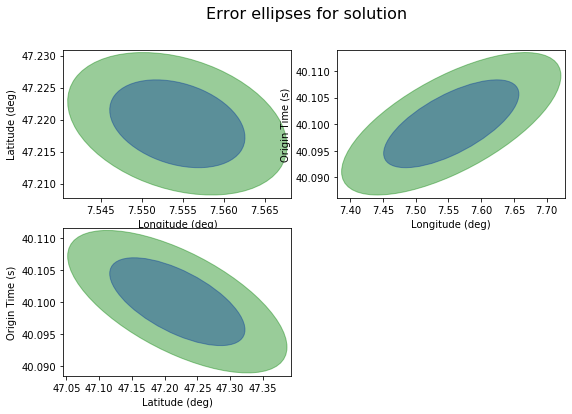

In [9]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# Plot Covariance ellipses and compare to Monte Carlo solutions

l68 = np.sqrt(stats.chi2.ppf(q=0.68,df=2)) # number of standard deviations equivalent to 68% confidence ellipse
l95 = np.sqrt(stats.chi2.ppf(q=0.95,df=2)) # number of standard deviations equivalent to 95% confidence ellipse

CmProj01 = Cm_cov[np.ix_([0,1],[0,1])]
CmProj02 = Cm_cov[np.ix_([0,2],[0,2])]
CmProj12 = Cm_cov[np.ix_([1,2],[1,2])]

fig = plt.figure(figsize=(9,6))
fig.suptitle("Error ellipses for solution", fontsize=16)

ax1 = plt.subplot("221")
pc.plot_cov_ellipse(CmProj12,sols[-1][1:], ax=ax1,nstd=l68,color='Blue',alpha=0.4,label='68% Confidence')
pc.plot_cov_ellipse(CmProj12,sols[-1][1:], ax=ax1,nstd=l95,color='Green',alpha=0.4,label='95% Confidence')
ax1.set_xlim(sols[-1][1]-1.3*1.96*sig_param2,sols[-1][1]+1.3*1.96*sig_param2)
ax1.set_ylim(sols[-1][2]-1.3*1.96*sig_param3,sols[-1][2]+1.3*1.96*sig_param3)
ax1.set_xlabel('Longitude (deg)')
ax1.set_ylabel('Latitude (deg)')

ax2 = plt.subplot("222")
pc.plot_cov_ellipse(CmProj01,[sols[-1][1],sols[-1][0]], ax=ax2,nstd=l68,color='Blue',alpha=0.4,label="68% Confidence")
pc.plot_cov_ellipse(CmProj01,[sols[-1][1],sols[-1][0]], ax=ax2,nstd=l95,color='Green',alpha=0.4,label="95% Confidence")
ax2.set_xlim(sols[-1][1]-1.3*1.96*sig_param1,sols[-1][1]+1.3*1.96*sig_param1)
ax2.set_ylim(sols[-1][0]-1.3*1.96*sig_param2,sols[-1][0]+1.3*1.96*sig_param2)
ax2.set_ylabel('Origin Time (s)')
ax2.set_xlabel('Longitude (deg)')

ax3 = plt.subplot("223")
pc.plot_cov_ellipse(CmProj02,[sols[-1][2],sols[-1][0]], ax=ax3,nstd=l68,color='Blue',alpha=0.4,label='68% Confidence')
pc.plot_cov_ellipse(CmProj02,[sols[-1][2],sols[-1][0]], ax=ax3,nstd=l95,color='Green',alpha=0.4,label='95% Confidence')
ax3.set_xlim(sols[-1][2]-1.3*1.96*sig_param1,sols[-1][2]+1.3*1.96*sig_param1)
ax3.set_ylim(sols[-1][0]-1.3*1.96*sig_param3,sols[-1][0]+1.3*1.96*sig_param3)
ax3.set_xlabel('Latitude (deg)')
ax3.set_ylabel('Origin Time (s)')
plt.savefig('test.jpg')
plt.show()